In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-01 20:36:14.452238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 20:36:14.456491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 20:36:14.456791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-01 20:36:14.732463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 20:36:14.733180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 20:36:14.733520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 20:36:14.733798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[4.4343739e+00, 0.0000000e+00, 0.0000000e+00],
         [1.8308710e+00, 0.0000000e+00, 0.0000000e+00],
         [1.5199649e-01, 0.0000000e+00, 1.0451701e+00],
         ...,
         [0.0000000e+00, 1.4448825e+00, 2.0164154e+00],
         [2.4874818e+00, 2.4779019e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 4.1192201e-01]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 7.5892407e-01],
         ...,
         [0.0000000e+00, 3.3068383e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 1.3362601e+00],
         [1.3816302e+00, 0.0000000e+00, 2.5660586e+00]],

        [[6.2202635e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 6.8149304e-01, 2.3058958e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [0.0000000e+00, 0.0000000e+00, 8.6884630e-01],


In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[4.4343739e+00, 0.0000000e+00, 0.0000000e+00],
          [1.8308710e+00, 0.0000000e+00, 0.0000000e+00],
          [1.5199649e-01, 0.0000000e+00, 1.0451701e+00],
          ...,
          [0.0000000e+00, 1.4448825e+00, 2.0164154e+00],
          [2.4874818e+00, 2.4779019e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 4.1192201e-01]],
 
         [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 7.5892407e-01],
          ...,
          [0.0000000e+00, 3.3068383e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 1.3362601e+00],
          [1.3816302e+00, 0.0000000e+00, 2.5660586e+00]],
 
         [[6.2202635e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 6.8149304e-01, 2.3058958e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          ...,
          [0.0000000e+00, 

<IPython.core.display.Javascript object>


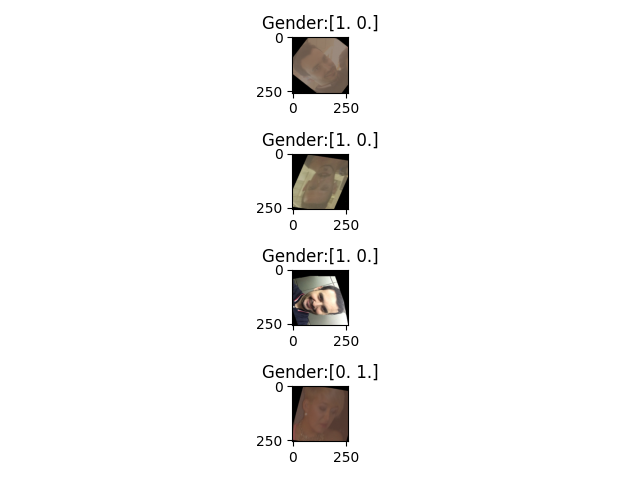

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [32]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv4'),
        tf.keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv5'),
        tf.keras.layers.Flatten(name="enc_flat"),
        tf.keras.layers.Dense(latentSize, name="enc_out")
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latentSize), name='dec_inp'),
        tf.keras.layers.Dense(8*8*64, activation='relu', name='dec_fc1'),
        tf.keras.layers.Reshape(target_shape=(8,8,64), name='dec_reshape'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='tanh', name='dec_deconv5')
    ], name='dec')

    fc1 = tf.keras.layers.Dense(128, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    o = fc1(latent)
    o = do1(o)
    
    outLab = fc2(o)
    
    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_4')
    
    #encoder.summary()
    #decoder.summary()
    
    return model

In [33]:
LATENT_SIZE = 32

In [34]:
model = createModel(LATENT_SIZE)

In [35]:
model.summary()

Model: "AE_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 32)           575712      ['tf.math.subtract[0][0]']    

### Compile Model

In [36]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [37]:
def schedule(epoch, lr):
    return lr

In [38]:
logBasePath = "log/AE_4"
logPrefix = "log"

In [39]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel(LATENT_SIZE)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    lossWeight = {"gender": 700, "recon": 1}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, loss_weights=lossWeight, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-01 20:36:22.693756: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-01 20:36:22.693776: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-01 20:36:22.693795: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-01 20:36:22.799114: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-01 20:36:22.800375: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-01 20:36:23.419085: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  14/3528 [..............................] - ETA: 13s - loss: 6016.4653 - gender_out_loss: 0.6930 - tf.math.multiply_1_loss: 5531.3325 - gender_out_accuracy: 0.5536    

2022-11-01 20:36:24.139426: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 14s 4ms/step - loss: 6476.3599 - gender_out_loss: 0.6938 - tf.math.multiply_1_loss: 5990.6929 - gender_out_accuracy: 0.4763
Epoch 1/300
   1/1000 [..............................] - ETA: 14:09 - loss: 7237.8950 - gender_out_loss: 0.6908 - tf.math.multiply_1_loss: 6754.3018 - gender_out_accuracy: 0.5000

2022-11-01 20:36:38.081710: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-01 20:36:38.081773: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


   8/1000 [..............................] - ETA: 1:10 - loss: 7847.8813 - gender_out_loss: 0.6930 - tf.math.multiply_1_loss: 7362.7959 - gender_out_accuracy: 0.5938

2022-11-01 20:36:38.586732: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-01 20:36:38.587605: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-01 20:36:38.624038: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 3188 callback api events and 3147 activity events. 
2022-11-01 20:36:38.652787: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-01 20:36:38.692435: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_4/log_0/plugins/profile/2022_11_01_20_36_38

2022-11-01 20:36:38.746734: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_4/log_0/plugins/profile/2022_11_01_20_36_38/rachanon-pc1.trace.json.gz


  32/1000 [..............................] - ETA: 28s - loss: 7741.2974 - gender_out_loss: 0.6888 - tf.math.multiply_1_loss: 7259.1289 - gender_out_accuracy: 0.6172

2022-11-01 20:36:38.788468: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_4/log_0/plugins/profile/2022_11_01_20_36_38

2022-11-01 20:36:38.794127: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to log/AE_4/log_0/plugins/profile/2022_11_01_20_36_38/rachanon-pc1.memory_profile.json.gz
2022-11-01 20:36:38.795167: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: log/AE_4/log_0/plugins/profile/2022_11_01_20_36_38
Dumped tool data for xplane.pb to log/AE_4/log_0/plugins/profile/2022_11_01_20_36_38/rachanon-pc1.xplane.pb
Dumped tool data for overview_page.pb to log/AE_4/log_0/plugins/profile/2022_11_01_20_36_38/rachanon-pc1.overview_page.pb
Dumped tool data for input_pipeline.pb to log/AE_4/log_0/plugins/profile/2022_11_01_20_36_38/rachanon-pc1.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to log/AE_4/log_0/plugins/profile/2022_11_01_20_36_38/ra

1000/1000 [==============================] - 22s 21ms/step - loss: 5554.4185 - gender_out_loss: 0.7450 - tf.math.multiply_1_loss: 5032.9399 - gender_out_accuracy: 0.5355 - val_loss: 4258.6411 - val_gender_out_loss: 0.7061 - val_tf.math.multiply_1_loss: 3764.3396 - val_gender_out_accuracy: 0.5136
Epoch 2/300
1000/1000 [==============================] - 20s 20ms/step - loss: 3787.1545 - gender_out_loss: 0.7158 - tf.math.multiply_1_loss: 3286.0906 - gender_out_accuracy: 0.5723 - val_loss: 3730.0720 - val_gender_out_loss: 0.6976 - val_tf.math.multiply_1_loss: 3241.7136 - val_gender_out_accuracy: 0.5190
Epoch 3/300
1000/1000 [==============================] - 20s 20ms/step - loss: 3280.4534 - gender_out_loss: 0.6908 - tf.math.multiply_1_loss: 2796.8997 - gender_out_accuracy: 0.5755 - val_loss: 3454.9417 - val_gender_out_loss: 0.6985 - val_tf.math.multiply_1_loss: 2965.9761 - val_gender_out_accuracy: 0.4864
Epoch 4/300
1000/1000 [==============================] - 20s 20ms/step - loss: 3098.3

1000/1000 [==============================] - 20s 20ms/step - loss: 1843.1448 - gender_out_loss: 0.6579 - tf.math.multiply_1_loss: 1382.6027 - gender_out_accuracy: 0.6050 - val_loss: 2148.3323 - val_gender_out_loss: 0.7585 - val_tf.math.multiply_1_loss: 1617.4000 - val_gender_out_accuracy: 0.5251
Epoch 28/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1886.3269 - gender_out_loss: 0.6861 - tf.math.multiply_1_loss: 1406.0881 - gender_out_accuracy: 0.5583 - val_loss: 2086.6787 - val_gender_out_loss: 0.6904 - val_tf.math.multiply_1_loss: 1603.4126 - val_gender_out_accuracy: 0.5372
Epoch 29/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1841.0601 - gender_out_loss: 0.6862 - tf.math.multiply_1_loss: 1360.7002 - gender_out_accuracy: 0.5500 - val_loss: 2071.6023 - val_gender_out_loss: 0.6804 - val_tf.math.multiply_1_loss: 1595.3391 - val_gender_out_accuracy: 0.5778
Epoch 30/300
1000/1000 [==============================] - 20s 20ms/step - loss: 183

1000/1000 [==============================] - 20s 20ms/step - loss: 1804.0570 - gender_out_loss: 0.6852 - tf.math.multiply_1_loss: 1324.4143 - gender_out_accuracy: 0.5602 - val_loss: 1989.6692 - val_gender_out_loss: 0.6804 - val_tf.math.multiply_1_loss: 1513.3751 - val_gender_out_accuracy: 0.5765
Epoch 54/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1753.9280 - gender_out_loss: 0.6847 - tf.math.multiply_1_loss: 1274.6594 - gender_out_accuracy: 0.5550 - val_loss: 2007.4585 - val_gender_out_loss: 0.6953 - val_tf.math.multiply_1_loss: 1520.7689 - val_gender_out_accuracy: 0.5031
Epoch 55/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1763.7180 - gender_out_loss: 0.6792 - tf.math.multiply_1_loss: 1288.2662 - gender_out_accuracy: 0.5790 - val_loss: 1980.7823 - val_gender_out_loss: 0.6758 - val_tf.math.multiply_1_loss: 1507.7194 - val_gender_out_accuracy: 0.5710
Epoch 56/300
1000/1000 [==============================] - 20s 20ms/step - loss: 177

1000/1000 [==============================] - 20s 20ms/step - loss: 1686.9216 - gender_out_loss: 0.6837 - tf.math.multiply_1_loss: 1208.3254 - gender_out_accuracy: 0.5502 - val_loss: 1934.0533 - val_gender_out_loss: 0.6729 - val_tf.math.multiply_1_loss: 1463.0043 - val_gender_out_accuracy: 0.5727
Epoch 80/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1689.2997 - gender_out_loss: 0.6550 - tf.math.multiply_1_loss: 1230.8198 - gender_out_accuracy: 0.6183 - val_loss: 1988.9360 - val_gender_out_loss: 0.6908 - val_tf.math.multiply_1_loss: 1505.4036 - val_gender_out_accuracy: 0.5461
Epoch 81/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1742.6207 - gender_out_loss: 0.6756 - tf.math.multiply_1_loss: 1269.7043 - gender_out_accuracy: 0.5875 - val_loss: 1958.6205 - val_gender_out_loss: 0.7035 - val_tf.math.multiply_1_loss: 1466.1742 - val_gender_out_accuracy: 0.5376
Epoch 82/300
1000/1000 [==============================] - 20s 20ms/step - loss: 173

1000/1000 [==============================] - 20s 20ms/step - loss: 1671.1848 - gender_out_loss: 0.6577 - tf.math.multiply_1_loss: 1210.7625 - gender_out_accuracy: 0.6070 - val_loss: 1924.1801 - val_gender_out_loss: 0.6778 - val_tf.math.multiply_1_loss: 1449.7167 - val_gender_out_accuracy: 0.5640
Epoch 106/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1676.4386 - gender_out_loss: 0.6771 - tf.math.multiply_1_loss: 1202.4808 - gender_out_accuracy: 0.5648 - val_loss: 1931.7117 - val_gender_out_loss: 0.6733 - val_tf.math.multiply_1_loss: 1460.4220 - val_gender_out_accuracy: 0.5838
Epoch 107/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1692.2672 - gender_out_loss: 0.6788 - tf.math.multiply_1_loss: 1217.0771 - gender_out_accuracy: 0.5715 - val_loss: 1914.3698 - val_gender_out_loss: 0.6725 - val_tf.math.multiply_1_loss: 1443.6313 - val_gender_out_accuracy: 0.5718
Epoch 108/300
1000/1000 [==============================] - 20s 20ms/step - loss: 

1000/1000 [==============================] - 20s 20ms/step - loss: 1698.3444 - gender_out_loss: 0.6709 - tf.math.multiply_1_loss: 1228.6935 - gender_out_accuracy: 0.5803 - val_loss: 1907.8080 - val_gender_out_loss: 0.6795 - val_tf.math.multiply_1_loss: 1432.1213 - val_gender_out_accuracy: 0.5599
Epoch 132/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1626.8177 - gender_out_loss: 0.6799 - tf.math.multiply_1_loss: 1150.8849 - gender_out_accuracy: 0.5615 - val_loss: 1908.2922 - val_gender_out_loss: 0.6751 - val_tf.math.multiply_1_loss: 1435.7313 - val_gender_out_accuracy: 0.5677
Epoch 133/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1610.5500 - gender_out_loss: 0.6476 - tf.math.multiply_1_loss: 1157.2316 - gender_out_accuracy: 0.6327 - val_loss: 1930.6826 - val_gender_out_loss: 0.6715 - val_tf.math.multiply_1_loss: 1460.6443 - val_gender_out_accuracy: 0.5712
Epoch 134/300
1000/1000 [==============================] - 20s 20ms/step - loss: 

1000/1000 [==============================] - 20s 20ms/step - loss: 1667.0093 - gender_out_loss: 0.6660 - tf.math.multiply_1_loss: 1200.8429 - gender_out_accuracy: 0.6030 - val_loss: 1906.8414 - val_gender_out_loss: 0.6753 - val_tf.math.multiply_1_loss: 1434.1361 - val_gender_out_accuracy: 0.5657
Epoch 158/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1629.2540 - gender_out_loss: 0.6589 - tf.math.multiply_1_loss: 1168.0364 - gender_out_accuracy: 0.6085 - val_loss: 1898.3092 - val_gender_out_loss: 0.6732 - val_tf.math.multiply_1_loss: 1427.0521 - val_gender_out_accuracy: 0.5674
Epoch 159/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1676.1766 - gender_out_loss: 0.6778 - tf.math.multiply_1_loss: 1201.6984 - gender_out_accuracy: 0.5685 - val_loss: 1897.1617 - val_gender_out_loss: 0.6772 - val_tf.math.multiply_1_loss: 1423.0996 - val_gender_out_accuracy: 0.5651
Epoch 160/300
1000/1000 [==============================] - 20s 20ms/step - loss: 

1000/1000 [==============================] - 20s 20ms/step - loss: 1639.2571 - gender_out_loss: 0.6606 - tf.math.multiply_1_loss: 1176.8167 - gender_out_accuracy: 0.5932 - val_loss: 1882.1890 - val_gender_out_loss: 0.6730 - val_tf.math.multiply_1_loss: 1411.0790 - val_gender_out_accuracy: 0.5709
Epoch 184/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1679.7300 - gender_out_loss: 0.6748 - tf.math.multiply_1_loss: 1207.3912 - gender_out_accuracy: 0.5760 - val_loss: 1872.2466 - val_gender_out_loss: 0.6715 - val_tf.math.multiply_1_loss: 1402.1611 - val_gender_out_accuracy: 0.5720
Epoch 185/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1638.9807 - gender_out_loss: 0.6754 - tf.math.multiply_1_loss: 1166.1714 - gender_out_accuracy: 0.5800 - val_loss: 1902.7324 - val_gender_out_loss: 0.6697 - val_tf.math.multiply_1_loss: 1433.9684 - val_gender_out_accuracy: 0.5829
Epoch 186/300
1000/1000 [==============================] - 20s 20ms/step - loss: 

1000/1000 [==============================] - 20s 20ms/step - loss: 1650.4583 - gender_out_loss: 0.6758 - tf.math.multiply_1_loss: 1177.4148 - gender_out_accuracy: 0.5645 - val_loss: 1871.8744 - val_gender_out_loss: 0.6741 - val_tf.math.multiply_1_loss: 1400.0284 - val_gender_out_accuracy: 0.5674
Epoch 210/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1642.9495 - gender_out_loss: 0.6610 - tf.math.multiply_1_loss: 1180.2810 - gender_out_accuracy: 0.6045 - val_loss: 1883.4543 - val_gender_out_loss: 0.6922 - val_tf.math.multiply_1_loss: 1398.9434 - val_gender_out_accuracy: 0.5552
Epoch 211/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1629.6566 - gender_out_loss: 0.6517 - tf.math.multiply_1_loss: 1173.4813 - gender_out_accuracy: 0.6170 - val_loss: 1870.6033 - val_gender_out_loss: 0.6724 - val_tf.math.multiply_1_loss: 1399.8929 - val_gender_out_accuracy: 0.5812
Epoch 212/300
1000/1000 [==============================] - 20s 20ms/step - loss: 

1000/1000 [==============================] - 20s 20ms/step - loss: 1629.7155 - gender_out_loss: 0.6724 - tf.math.multiply_1_loss: 1159.0339 - gender_out_accuracy: 0.5970 - val_loss: 1873.9196 - val_gender_out_loss: 0.6772 - val_tf.math.multiply_1_loss: 1399.8900 - val_gender_out_accuracy: 0.5672
Epoch 236/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1636.9707 - gender_out_loss: 0.6561 - tf.math.multiply_1_loss: 1177.7349 - gender_out_accuracy: 0.5968 - val_loss: 1874.2302 - val_gender_out_loss: 0.6727 - val_tf.math.multiply_1_loss: 1403.3156 - val_gender_out_accuracy: 0.5737
Epoch 237/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1631.6818 - gender_out_loss: 0.6672 - tf.math.multiply_1_loss: 1164.6688 - gender_out_accuracy: 0.5795 - val_loss: 1864.6877 - val_gender_out_loss: 0.6696 - val_tf.math.multiply_1_loss: 1395.9990 - val_gender_out_accuracy: 0.5820
Epoch 238/300
1000/1000 [==============================] - 20s 20ms/step - loss: 

1000/1000 [==============================] - 20s 20ms/step - loss: 1644.6213 - gender_out_loss: 0.6740 - tf.math.multiply_1_loss: 1172.7863 - gender_out_accuracy: 0.5832 - val_loss: 1868.1567 - val_gender_out_loss: 0.6867 - val_tf.math.multiply_1_loss: 1387.4790 - val_gender_out_accuracy: 0.5601
Epoch 262/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1612.3987 - gender_out_loss: 0.6754 - tf.math.multiply_1_loss: 1139.6331 - gender_out_accuracy: 0.5803 - val_loss: 1858.4900 - val_gender_out_loss: 0.6670 - val_tf.math.multiply_1_loss: 1391.5674 - val_gender_out_accuracy: 0.5815
Epoch 263/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1606.0957 - gender_out_loss: 0.6607 - tf.math.multiply_1_loss: 1143.6200 - gender_out_accuracy: 0.6143 - val_loss: 1874.7029 - val_gender_out_loss: 0.6841 - val_tf.math.multiply_1_loss: 1395.8680 - val_gender_out_accuracy: 0.5651
Epoch 264/300
1000/1000 [==============================] - 20s 20ms/step - loss: 

1000/1000 [==============================] - 20s 20ms/step - loss: 1598.5060 - gender_out_loss: 0.6755 - tf.math.multiply_1_loss: 1125.6573 - gender_out_accuracy: 0.5780 - val_loss: 1864.3484 - val_gender_out_loss: 0.6709 - val_tf.math.multiply_1_loss: 1394.6936 - val_gender_out_accuracy: 0.5839
Epoch 288/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1577.3292 - gender_out_loss: 0.6555 - tf.math.multiply_1_loss: 1118.4442 - gender_out_accuracy: 0.6152 - val_loss: 1930.8630 - val_gender_out_loss: 0.7734 - val_tf.math.multiply_1_loss: 1389.4661 - val_gender_out_accuracy: 0.5416
Epoch 289/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1621.3407 - gender_out_loss: 0.6705 - tf.math.multiply_1_loss: 1151.9752 - gender_out_accuracy: 0.5895 - val_loss: 1858.0044 - val_gender_out_loss: 0.6753 - val_tf.math.multiply_1_loss: 1385.3120 - val_gender_out_accuracy: 0.5696
Epoch 290/300
1000/1000 [==============================] - 20s 20ms/step - loss: 

In [40]:
out = model(x)

In [41]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[5.68639469e+00, 3.01348162e+00, 1.95706975e+00],
          [1.94547284e+00, 5.95481277e-01, 1.73618770e+00],
          [1.98224723e+00, 1.17363548e+00, 6.18819594e-01],
          ...,
          [1.52235031e+01, 1.02903414e+01, 1.07822866e+01],
          [1.89522362e+01, 1.35550585e+01, 1.31719551e+01],
          [2.67156448e+01, 2.14538841e+01, 2.29595985e+01]],
 
         [[2.27844906e+00, 2.89124203e+00, 1.01985002e+00],
          [7.82560408e-01, 2.58880109e-01, 4.51332182e-01],
          [4.62488383e-01, 1.92619264e-01, 1.69888884e-01],
          ...,
          [8.39090729e+00, 4.57238579e+00, 7.18646336e+00],
          [1.02915955e+01, 7.46710110e+00, 7.27347851e+00],
          [1.73378925e+01, 1.35412197e+01, 1.39999456e+01]],
 
         [[6.94420338e-01, 8.00518274e-01, 1.10516310e+00],
          [3.20056826e-01, 9.30950046e-02, 1.24207735e-01],
          [7.44228065e-02, 4.55443561e-02, 1.49765164e-0

<IPython.core.display.Javascript object>


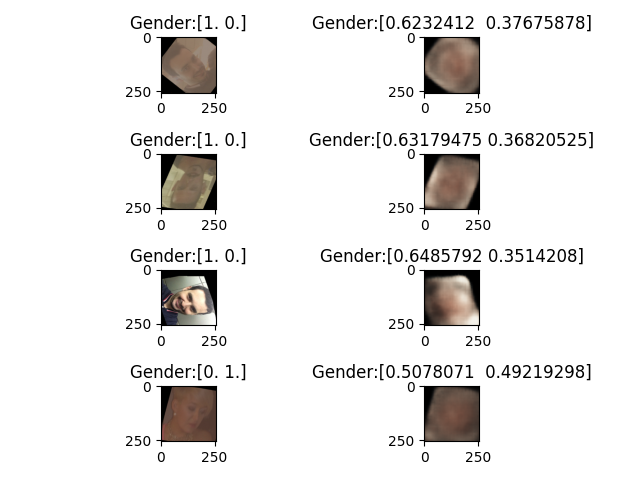

In [42]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()